In [1]:
import matplotlib.pyplot as plt
import numpy as np  

In [2]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, GPT2LMHeadModel

/lustre/hpc/pheno/inar/mambaforge/envs/torch39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# tokenizer = AutoTokenizer.from_pretrained("gpt2")
# model = GPT2LMHeadModel.from_pretrained("gpt2")

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-v0.1")
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")

Loading checkpoint shards: 100%|██████████| 2/2 [01:21<00:00, 40.76s/it]


### Get unembedding matrix and its pseudo-inverse

In [4]:
#Where is it documented?
# Check if works for all models 
unembed = model.get_output_embeddings().weight.detach()

In [5]:
vocab_size, hidden_dim = unembed.shape
vocab_size, hidden_dim

(32000, 4096)

In [6]:
# cross check
inputs = tokenizer("This is a test", return_tensors="pt")
outputs = model(**inputs, labels=inputs["input_ids"], output_hidden_states=True)

test_logits = outputs.logits.detach()
explicit_logits = outputs.hidden_states[-1] @ unembed.T

assert torch.allclose(test_logits, explicit_logits)

In [7]:
Wai = unembed.numpy()
pinvWai = np.linalg.pinv(Wai) 

In [12]:
np.allclose(pinvWai @ Wai, np.eye(hidden_dim), atol = 1e-6)

True

### Iso-Logit vector

This vector is mapped into $\ell_i = 1$. If added to any logit, it doesn't change the probability distribution

$$ p_i = \exp(\ell_i - F), \; F = - \log(Z) $$

Any constant shift $\ell_i \to \ell_i +C$ is abosrbed in F and doesn't change the probability distribution.



In [13]:
iso_vec = pinvWai @ np.ones(vocab_size)

In [14]:
iso_tensor = torch.tensor(iso_vec, dtype=torch.float32)

In [20]:
iso_logits = iso_tensor @ unembed.T
iso_p = F.softmax(iso_logits, dim=-1)

iso_p.sum(), iso_p.max()*vocab_size, iso_p.std()*vocab_size

(tensor(1.0000), tensor(3.2219), tensor(0.1616))

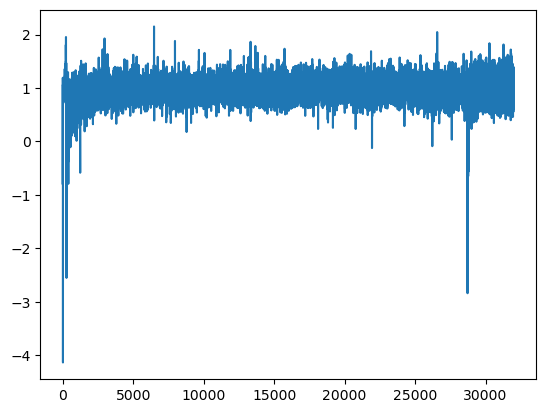

In [53]:
plt.plot(iso_logits)

In [22]:
topk_iso_comp = torch.topk(iso_tensor.abs(),5)
topk_iso_comp

torch.return_types.topk(
values=tensor([28.9464, 26.9456, 24.5323, 16.8218, 15.7275]),
indices=tensor([1375,   53, 1125,  835,   93]))

In [47]:
iso_candidates = []
for i, v in zip(topk_iso_comp.indices, topk_iso_comp.values):
    if v > 0.5:
        iso_candidate = torch.zeros(hidden_dim)
        iso_candidate[i] = iso_tensor[i]
        iso_candidates.append(iso_candidate)

In [48]:
for candidate in iso_candidates:
    candidate_logits = candidate @ unembed.T
    candidate_p = F.softmax(candidate_logits, dim=-1)
    print(candidate_p.max()*vocab_size, candidate_p.std()*vocab_size)

tensor(1.6845) tensor(0.1025)
tensor(1.5215) tensor(0.1267)
tensor(2.9006) tensor(0.1589)
tensor(1.4777) tensor(0.0619)
tensor(1.7092) tensor(0.0660)


In [49]:
test_logits.shape

torch.Size([1, 5, 32000])

In [50]:
for logits in test_logits[0]:
    ptt = F.softmax(logits, dim=-1)
    print(ptt.max()*vocab_size, ptt.std()*vocab_size)

tensor(9057.3135) tensor(55.2602)
tensor(6912.3027) tensor(45.2023)
tensor(10427.5703) tensor(74.5421)
tensor(1960.4727) tensor(18.0274)
tensor(5597.8765) tensor(45.9302)


In [54]:
max_ps = []
ps_std = []
for i in range(hidden_dim):
    candidate = torch.zeros(hidden_dim)
    candidate[i] = 20.0
    candidate_logits = candidate @ unembed.T
    candidate_p = F.softmax(candidate_logits, dim=-1)
    max_ps.append(candidate_p.max())
    ps_std.append(candidate_p.std())

    

In [44]:
max_ps[-1]

1.4021009

In [57]:
max_ps = np.array(max_ps)
ps_std = np.array(ps_std)

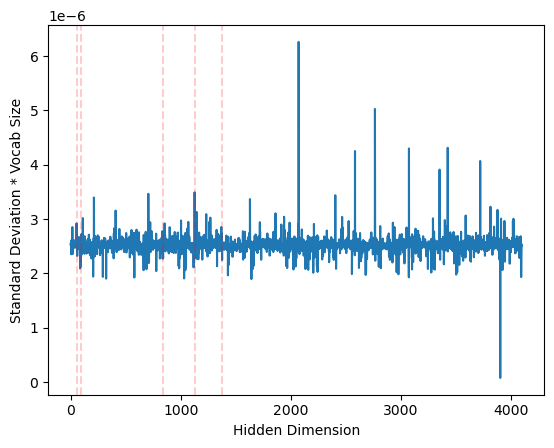

In [58]:
plt.plot(ps_std)
# add hline at iso_p.std()*vocab_size
for i in topk_iso_comp.indices:
    plt.axvline(i, color='r', linestyle='--', alpha=0.2, label = 'iso candidates')
# plt.hlines(iso_p.std()*vocab_size, 0, hidden_dim, color='g', linestyle='--', alpha=0.5)
plt.xlabel('Hidden Dimension')
plt.ylabel('Standard Deviation * Vocab Size')

plt.show()

Text(0, 0.5, 'max probability*vocab_size')

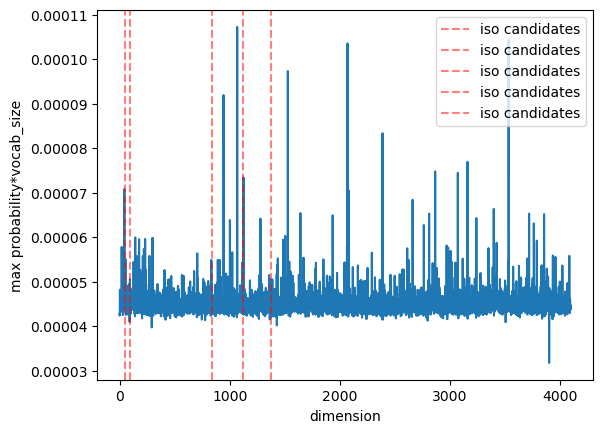

In [59]:
plt.plot(max_ps)
# add vertical lines at topk_iso_comp.indices
for i in topk_iso_comp.indices:
    plt.axvline(i, color='r', linestyle='--', alpha=0.5, label = 'iso candidates')
plt.legend()
plt.xlabel('dimension')
plt.ylabel('max probability*vocab_size')